In [1]:
from fairchem.core.datasets import LmdbDataset
from models.SchNETPeriodic import SchNet_model
from utils import AtomGraphConverter, process_oc20_input, inference_oc20, get_chemical_formula_string
from train import OC20_SE_config as config
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
from ase import Atoms
import copy
from pymatgen.io.ase import AseAtomsAdaptor


In [2]:
# Data Retrieval
lmdb_path1 = "data/metals_5000"
lmdb_path2 = "data/nonmetals_5000"
metal_data = LmdbDataset({'src': lmdb_path1})
nonmetal_data = LmdbDataset({'src': lmdb_path2})

In [3]:
# Data preprocessing
converter = AtomGraphConverter(cutoff=6.0, max_neighbors=50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

metal_input_data = process_oc20_input(metal_data, converter, device)
nonmetal_input_data = process_oc20_input(nonmetal_data, converter, device)
test_loader_in = DataLoader(metal_input_data, batch_size=1, shuffle=False)
test_loader_out = DataLoader(nonmetal_input_data, batch_size=1, shuffle=False)


In [4]:
# Load model checkpoint
model = SchNet_model(**config.model_config).to(device)
model.load_state_dict(torch.load('checkpoints/OC20-SE.pth', map_location=device, weights_only=False), strict=False)
model.eval()

SchNet_model(hidden_channels=1024, num_filters=256, num_interactions=5, num_gaussians=200, cutoff=6.0)

In [5]:
# model inference 
# in-domain: Inter-metallic slabs
pred_per_atom_in, true_per_atom_in, var_per_atom_in= inference_oc20(model, test_loader_in, device)
# out-of-domain: Non-metal slabs
pred_per_atom_out, true_per_atom_out, var_per_atom_out = inference_oc20(model, test_loader_out, device)


# 1. Inter-metallic and Non-metal slabs 

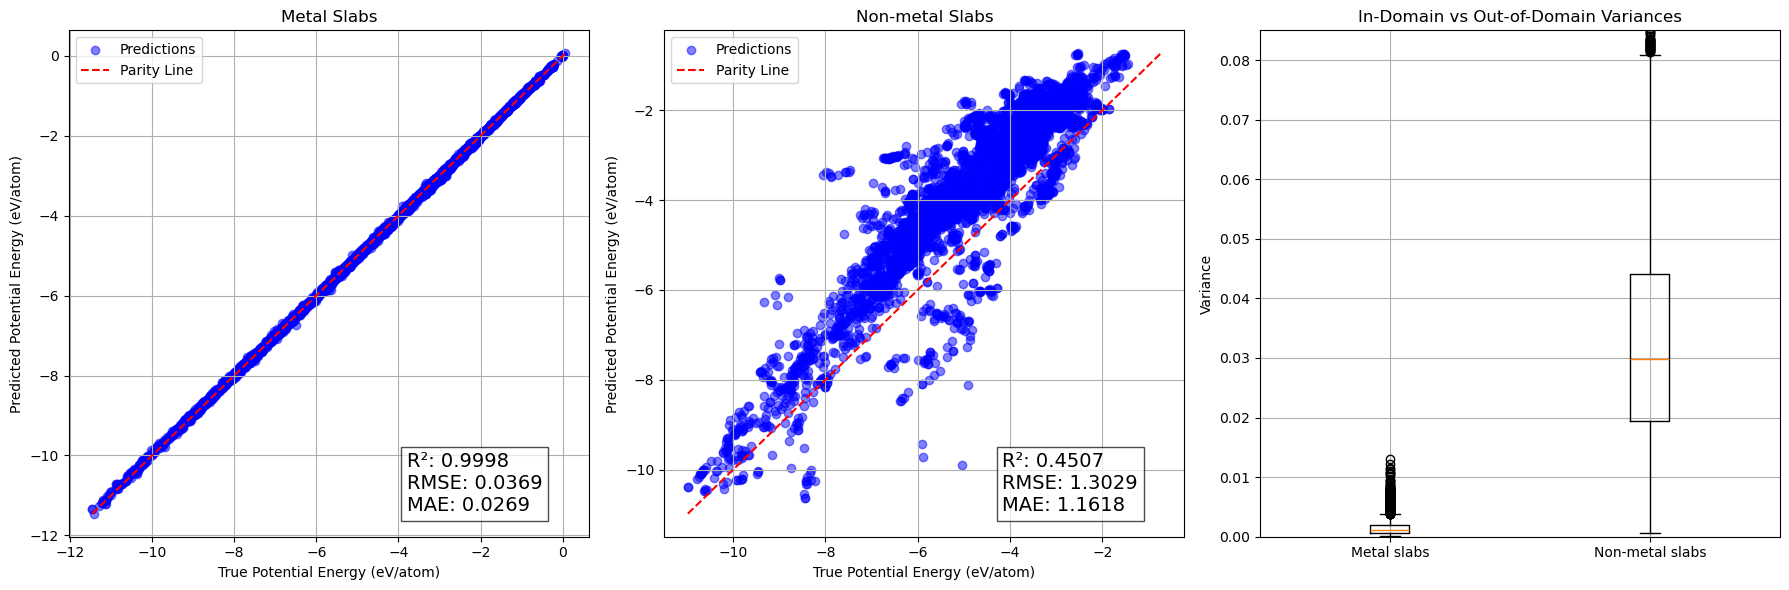

In [6]:
# Calculate metrics for both in-domain and out-of-domain
r2_in = r2_score(true_per_atom_in, pred_per_atom_in)
mae_in = mean_absolute_error(true_per_atom_in, pred_per_atom_in)
rmse_in = np.sqrt(mean_squared_error(true_per_atom_in, pred_per_atom_in))

r2_out = r2_score(true_per_atom_out, pred_per_atom_out)
mae_out = mean_absolute_error(true_per_atom_out, pred_per_atom_out)
rmse_out = np.sqrt(mean_squared_error(true_per_atom_out, pred_per_atom_out))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Parity plot for in-domain
axs[0].scatter(true_per_atom_in, pred_per_atom_in, alpha=0.5, label='Predictions', color='b')
min_val, max_val = min(true_per_atom_in + pred_per_atom_in), max(true_per_atom_in + pred_per_atom_in)
axs[0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Parity Line')

axs[0].set_xlabel('True Potential Energy (eV/atom)')
axs[0].set_ylabel('Predicted Potential Energy (eV/atom)')
axs[0].set_title('Metal Slabs')
axs[0].legend()
axs[0].grid(True)
axs[0].text(0.65, 0.05, f'R²: {r2_in:.4f}\nRMSE: {rmse_in:.4f}\nMAE: {mae_in:.4f}', 
            transform=axs[0].transAxes, fontsize=14, bbox=dict(facecolor='white', alpha=0.7))

# Plot 2: Parity plot for out-of-domain
axs[1].scatter(true_per_atom_out, pred_per_atom_out, alpha=0.5, label='Predictions', color='b')
min_val, max_val = min(true_per_atom_out + pred_per_atom_out), max(true_per_atom_out + pred_per_atom_out)
axs[1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Parity Line')

axs[1].set_xlabel('True Potential Energy (eV/atom)')
axs[1].set_ylabel('Predicted Potential Energy (eV/atom)')
axs[1].set_title('Non-metal Slabs')
axs[1].legend()
axs[1].grid(True)
axs[1].text(0.65, 0.05, f'R²: {r2_out:.4f}\nRMSE: {rmse_out:.4f}\nMAE: {mae_out:.4f}', 
            transform=axs[1].transAxes, fontsize=14, bbox=dict(facecolor='white', alpha=0.7))

# Plot 3: Boxplot for variances
axs[2].boxplot([var_per_atom_in, var_per_atom_out], tick_labels=['Metal slabs', 'Non-metal slabs'])
axs[2].set_ylim(0, 0.085)
axs[2].set_title('In-Domain vs Out-of-Domain Variances')
axs[2].set_ylabel('Variance')
axs[2].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# 2. Volume per atom compression & expansion

/tmp/ipykernel_116008/627307793.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789563135/work/torch/csrc/utils/tensor_new.cpp:278.)
  strained_cell = torch.tensor(strained_atoms.get_cell(), dtype=torch.float32).to(device)


Nb16Ru32Sn16
original volume per atom is: 11.744366711089238



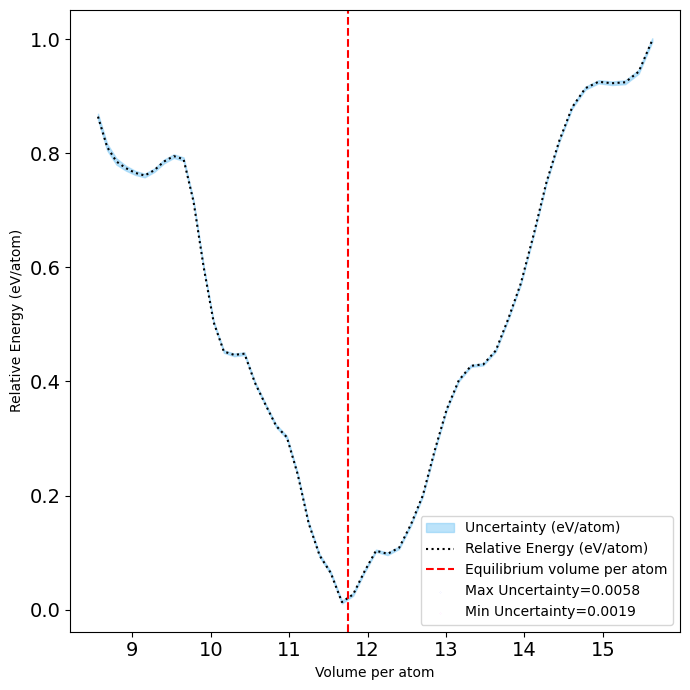

In [7]:
slab = metal_input_data[2858].to(device)
# slab = nonmetal_input_data[1444].to(device)

# Converting to Ase Atoms object
atoms = Atoms(numbers=slab.z.cpu(), positions=slab.pos.cpu(), cell=slab.cell.cpu(), pbc=True)
original_vol = slab.cell[0][0].item()**3


strain_range = np.linspace(-0.1, 0.1, 50) # for inter-metallic slab
# strain_range = np.linspace(-0.5, 0.5, 30) # for non-metal slab
uncertainties = []  
E =[]
strain=[]
vol_per_atom = []
pred_per_atom=[]
base_energy=0
for i in strain_range:
    structure = AseAtomsAdaptor.get_structure(atoms)
    structure.apply_strain(i) 
    strained_atoms = AseAtomsAdaptor.get_atoms(structure)
    edge_index, edge_weight, _ = converter(strained_atoms)

    # Update slab positions in the PyTorch data object
    strained_positions = torch.tensor(strained_atoms.get_positions(), dtype=torch.float32).to(device)
    strained_cell = torch.tensor(strained_atoms.get_cell(), dtype=torch.float32).to(device)
    copy_slab = copy.deepcopy(slab)
    copy_slab.pos = strained_positions
    copy_slab.cell = strained_cell
    copy_slab.edge_index = edge_index.to(device)
    copy_slab.edge_weight = edge_weight.to(device)
    num_atoms = copy_slab.z.size(0)
    energy = model(copy_slab)
    pred_mean = energy.detach().mean(dim=1).item()
    energy_per_atom = energy / num_atoms

    val_var = torch.var(energy, dim=1, unbiased=False).item()
    val_per_atom = torch.var(energy_per_atom, dim=1, unbiased=False).item()

    p_per_atom = pred_mean / num_atoms
    
    # Store energy
    E.append(np.abs(p_per_atom - (slab.y.detach().item()/num_atoms)))
    strain.append(i)

    uncertainties.append(val_per_atom)

    # Calculate volume per atom
    volume_per_atom = np.array(strained_cell[0][0].item()**3 / num_atoms)
    vol_per_atom.append(volume_per_atom)
E = np.array(E)
uncertainties = np.array(uncertainties).squeeze()
vol_per_atom = np.array(vol_per_atom)

print(get_chemical_formula_string(atoms))
print(f'original volume per atom is: {original_vol/slab.z.size(0)}')

fig, ax1 = plt.subplots(figsize=(7,7))
ax1.fill_between(vol_per_atom, E+uncertainties, E-uncertainties, label="Uncertainty (eV/atom)", color='xkcd:lightblue', alpha=0.5)
ax1.plot(vol_per_atom, E, label="Relative Energy (eV/atom)", color='xkcd:black', linestyle=':')
ax1.set_xlabel('Volume per atom')
ax1.set_ylabel('Relative Energy (eV/atom)')
ax1.axvline(x=original_vol/slab.z.size(0), color='red', linestyle='--', label='Equilibrium volume per atom')
ax1.tick_params(axis='both', which='major', labelsize=14)

# Retreive the max and min value of uncertainity
max_uncertainty_idx = np.argmax(uncertainties)
min_uncertainty_idx = np.argmin(uncertainties)

# Retrieve the corresponding volume per atom for these points
max_uncertainty_vol = vol_per_atom[max_uncertainty_idx]
min_uncertainty_vol = vol_per_atom[min_uncertainty_idx]

# Retrieve the uncertainty values
max_uncertainty = uncertainties[max_uncertainty_idx]
min_uncertainty = uncertainties[min_uncertainty_idx]

# Add dots and annotations to the plot
ax1.scatter(max_uncertainty_vol, E[max_uncertainty_idx] , color='blue', label=f"Max Uncertainty={max_uncertainty:.4f} ", zorder=3,  s=0.0005 )
ax1.scatter(min_uncertainty_vol, E[min_uncertainty_idx], color='magenta', label=f"Min Uncertainty={min_uncertainty:.4f}", zorder=3,  s=0.0005 )


# Add the legend
ax1.legend()

# plt.xlim(88,92)
fig.tight_layout()
fig.patch.set_facecolor('white')
print()